In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
def rbf_kernel(x1, x2, dt, sigma=1.0):
    y = np.square(x1[:, None, :] - x2[None, :, :])
    integral = np.sum(dt * (y[...,:-1] + y[...,1:]) * 0.5, axis=-1)
    return np.exp(-1 / (2*sigma**2) * integral)

# Gaussian Process Regression class
class GaussianProcess:
    def __init__(self, kernel, noise=1e-8):
        self.kernel = kernel
        self.noise = noise

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.K = self.kernel(X_train, X_train) + self.noise * np.eye(len(X_train))
        self.K_inv = np.linalg.inv(self.K)


    def predict(self, X_s):
        K_s = self.kernel(self.X_train, X_s)
        K_ss = self.kernel(X_s, X_s) + 1e-8 * np.eye(len(X_s))
        
        mu_s = K_s.T.dot(self.K_inv).dot(self.y_train)
        cov_s = K_ss - K_s.T.dot(self.K_inv).dot(K_s)
        return mu_s, cov_s

In [3]:
N = 100
num = 10
dt = 1/(N-1)
t = np.linspace(0,1,N)

def generate_brownian(num, N):
    incs = np.sqrt(dt) * np.random.randn(num, N-1)
    W = np.concatenate((np.zeros((num,1)), np.cumsum(incs, axis=1)), axis=1)
    return W

X_train = generate_brownian(num, N)
X_test = generate_brownian(3, N)

# Training data (noisy observations)
y_train = X_train[:,-1] + 0.1 * np.random.randn(X_train.shape[0])
y_test = X_test[:,-1]

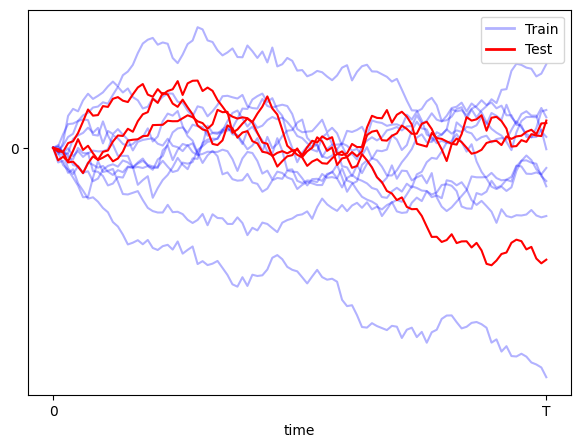

In [4]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(t, X_train.T, color="blue", alpha=0.3)
ax.plot(t, X_test.T, color="red")
ax.set_xlabel('time')
ax.set_yticks([0])
ax.set_xticks([0,1]); ax.set_xticklabels([0,'T'])

custom_lines = [Line2D([0], [0], color="blue", alpha=0.3, lw=2),
                Line2D([0], [0], color="red", lw=2)]
ax.legend(custom_lines, ['Train', 'Test'])
plt.show()

In [5]:
# Fit GP and predict
gp = GaussianProcess(lambda x1, x2: rbf_kernel(x1, x2, dt=dt))
gp.fit(X_train, y_train)
mu_s, cov_s = gp.predict(X_test)
std_s = np.sqrt(np.diag(cov_s))

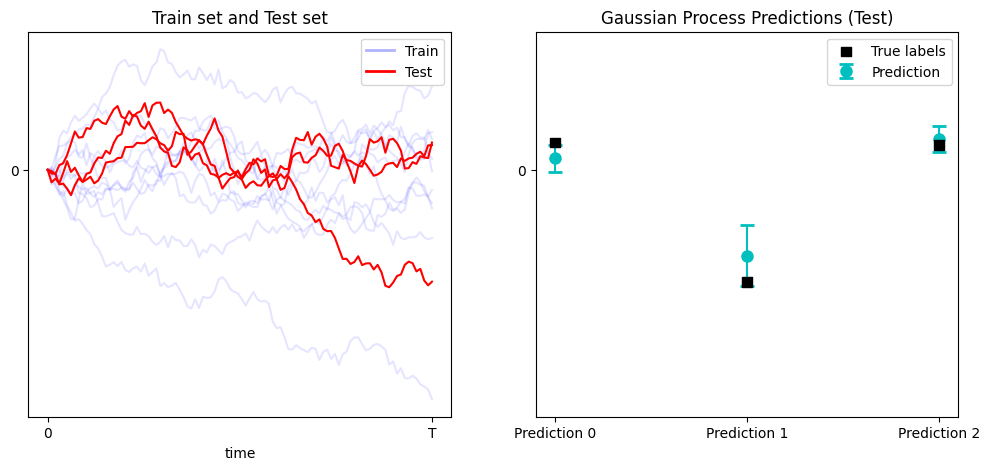

In [6]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
ax1, ax2 = axs.flatten()

ax1.plot(t, X_train.T, color="blue", alpha=0.1)
ax1.plot(t, X_test.T, color="red")
ax1.set_xlabel('time')
ax1.set_yticks([0]); ax2.set_yticks([0])
ax1.set_xticks([0,1]); ax1.set_xticklabels([0,'T'])
custom_lines = [Line2D([0], [0], color="blue", alpha=0.3, lw=2), Line2D([0], [0], color="red", lw=2)]
ax1.legend(custom_lines, ['Train', 'Test'])
ax1.set_title("Train set and Test set")

x_pos = np.arange(len(y_test))
ax2.errorbar(x_pos, mu_s, yerr=std_s, color="c", fmt='o', label="Prediction", zorder=1,capsize=5, capthick=2, markersize=8, )
ax2.set_title('Gaussian Process Predictions (Test)')
ax2.set_xticks(x_pos, [f'Prediction {i}' for i in range(len(y_test))])
ax2.grid(False)
# Add value labels
ax2.scatter(x_pos, y_test, c=["k", "k", "k"], label="True labels", zorder=2, marker="s", s=50)
ax2.legend()
ax2.set_ylim(ax1.get_ylim())
plt.show()